### Todo

#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [10]:
import os 
#Input the directory where your joined_data.csv is located 
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
#os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

#Where you want the csv file of the merged data to be placed
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

from matplotlib import pyplot
import pandas as pd 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)


#### In this cell we import our training data, convert HALL into HALL_EVER and select only BL observations.

In [11]:
train = pd.read_csv('train.csv')
temptrain = pd.DataFrame(train.PATNO.unique(), columns = ["PATNO"])

HALL_EVER = []
for id in train.PATNO.unique():
    if train.loc[(train.PATNO == id) & (train.HALL == 1), "HALL"].empty:
        HALL_EVER.append(0)
    else:
        HALL_EVER.append(1)

temptrain["HALL_EVER"] = HALL_EVER
train.drop("HALL", axis = 1, inplace = True)
train = train.merge(temptrain, how = "inner", on = "PATNO")

#Selecting only Baseline observations
train = train.loc[train.EVENT_ID == "BL", :]

#We can then safely drop EVENT_ID and PATNO
train.drop(["EVENT_ID", "PATNO"], axis = 1, inplace = True)

# We form Y
Y = train.pop("HALL_EVER")

In [12]:
train.shape

(293, 21)

#### In this cell we apply random forest from XGBOOST

   train-error-mean  train-error-std  train-auc-mean  train-auc-std  \
0          0.148643          0.01365        0.928653       0.007044   

   train-aucpr-mean  train-aucpr-std  test-error-mean  test-error-std  \
0          0.866624         0.013867         0.251954        0.087703   

   test-auc-mean  test-auc-std  test-aucpr-mean  test-aucpr-std  
0       0.639569      0.154095         0.498841        0.175736  


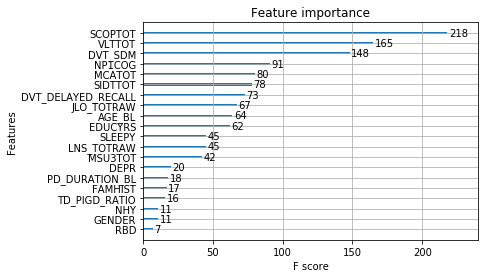

In [13]:
dtrain = xgb.DMatrix(train, label = Y)


#Random Forest
params = {
  'colsample_bynode': 0.8,
  'learning_rate': 1,
  'max_depth': 5,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.8,
  'tree_method': 'auto'
}

cv_results_RF = xgb.cv(params, dtrain = dtrain, num_boost_round=1, nfold = 10, as_pandas = True, seed = 1, metrics = ["error", "auc", "aucpr"])
print(cv_results_RF)

model_RF = xgb.train(params, dtrain, num_boost_round=1)
xgb.plot_importance(model_RF)
pyplot.show()

#### In this cell we apply random forest from XGBOOST

   train-error-mean  train-error-std  train-auc-mean  train-auc-std  \
0          0.155474         0.010371        0.853375       0.034481   
1          0.125904         0.010752        0.921841       0.008933   
2          0.108835         0.011115        0.947514       0.011607   
3          0.092918         0.009269        0.967275       0.008385   
4          0.077732         0.009101        0.982623       0.005848   
5          0.067116         0.008092        0.989967       0.005315   
6          0.055368         0.008347        0.995145       0.003190   
7          0.043991         0.006832        0.997530       0.002159   
8          0.034510         0.009506        0.998955       0.001214   
9          0.027310         0.007939        0.999418       0.001070   

   train-aucpr-mean  train-aucpr-std  test-error-mean  test-error-std  \
0          0.765128         0.031428         0.323793        0.112774   
1          0.857191         0.009811         0.279196        0.101635   

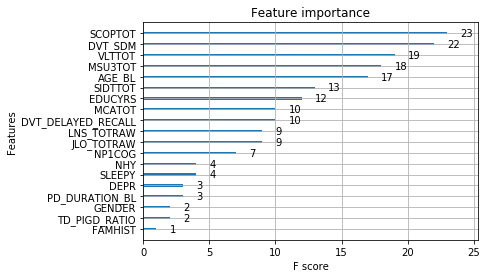

In [14]:
#Boosted trees
params = {
  'objective': 'binary:logistic',
  'tree_method': 'auto'
}

cv_results_BT = xgb.cv(params, dtrain = dtrain, num_boost_round=10, nfold = 10, as_pandas = True, seed = 1, metrics = ["error", "auc", "aucpr"])
print(cv_results_BT)

model_BT = xgb.train(params, dtrain, num_boost_round=10)
xgb.plot_importance(model_BT)
pyplot.show()

#### In this cell we apply SVM from scikit-learn

In [15]:
clf1 = svm.SVC(random_state=0, gamma='auto', kernel='rbf')
roc_auc1 = cross_val_score(clf1, train, Y, cv=10, scoring='roc_auc')
roc_auc1

array([0.71590909, 0.63636364, 0.44318182, 0.42857143, 0.67857143,
       0.66666667, 0.76785714, 0.6547619 , 0.70238095, 0.63690476])

In [16]:
accuracy1 = cross_val_score(clf1, train, Y, cv=10, scoring='accuracy')
accuracy1

array([0.73333333, 0.73333333, 0.73333333, 0.72413793, 0.72413793,
       0.72413793, 0.75862069, 0.75862069, 0.72413793, 0.75862069])

In [17]:
clf2 = svm.SVC(random_state=0, gamma='auto', kernel='linear')
roc_auc2 = cross_val_score(clf2, train, Y, cv=10, scoring='roc_auc')
roc_auc2

array([0.76704545, 0.72159091, 0.47727273, 0.39880952, 0.64285714,
       0.60714286, 0.70833333, 0.55952381, 0.75595238, 0.69642857])

In [18]:
accuracy2 = cross_val_score(clf2, train, Y, cv=10, scoring='accuracy')
accuracy2

array([0.76666667, 0.76666667, 0.7       , 0.65517241, 0.79310345,
       0.68965517, 0.79310345, 0.65517241, 0.86206897, 0.75862069])